# Data and Library loading


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

In [3]:
df=pd.read_csv('/content/Crime_Data_from_2020_to_Present.csv')

# Cleaning data and converting to 3NF

In [4]:
# Drop unnecessary columns
df.drop(columns=['Mocodes', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'Cross Street'], inplace=True)

# Drop rows with null values in specific columns
df.dropna(subset=['Premis Cd', 'Premis Desc', 'Status', 'Crm Cd 1'], inplace=True)


In [6]:
# Function to transform "TIME OCC" to HH:MM:SS format
def transform_time(time):
    time_str = str(time).zfill(4)
    if len(time_str) == 4:
        return f"{time_str[:2]}:{time_str[2:]}:00"
    elif len(time_str) == 3:
        return f"0{time_str[:1]}:{time_str[1:]}:00"
    elif len(time_str) == 2:
        return f"00:{time_str}:00"
    elif len(time_str) == 1:
        return f"0{time_str}:00:00"
    else:
        return None  # Return None for invalid time formats

df["TIME OCC"] = df["TIME OCC"].apply(transform_time)


In [7]:
df["Date Rptd"] = pd.to_datetime(df["Date Rptd"], format="%m/%d/%Y %I:%M:%S %p").dt.date
df["DATE OCC"] = pd.to_datetime(df["DATE OCC"], format="%m/%d/%Y %I:%M:%S %p").dt.date

In [8]:
# Replace invalid ages with NaN
df.loc[df['Vict Age'] <= 0, 'Vict Age'] = np.nan
df['Vict Age'] = df['Vict Age'].astype('Int64')

# Replace NaN in 'Weapon Used Cd' with 0
df['Weapon Used Cd'] = df['Weapon Used Cd'].fillna(0)

# Replace NaN in 'Weapon Desc' with "No weapon used"
df['Weapon Desc'] = df['Weapon Desc'].fillna("No weapon used")

In [9]:
df['Vict Age'] = df.groupby('Crm Cd')['Vict Age'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)
)

In [10]:
# Keep only valid values for Vict Sex
df['Vict Sex'] = df['Vict Sex'].apply(lambda x: x if x in ['M', 'F'] else None)

# Remove non-alphabet characters from Vict Descent
df['Vict Descent'] = df['Vict Descent'].replace(to_replace=r'[^a-zA-Z]', value=None, regex=True)

In [11]:
df.rename(columns={
    'DR_NO':'case_number', 'Date Rptd':'date_reported', 'DATE OCC':'date_occurred',
    'TIME OCC':'time_occurred', 'AREA':'area_id', 'AREA NAME':'area_name', 'Rpt Dist No':'report_district_number',
    'Part 1-2':'crime_severity', 'Crm Cd':'crime_code', 'Crm Cd Desc':'crime_code_description',
    'Vict Age':'victim_age', 'Vict Sex':'victim_sex', 'Vict Descent':'victim_descent', 'Premis Cd':'premise_code',
    'Premis Desc':'premise_description', 'Weapon Used Cd':'weapon_code', 'Weapon Desc':'weapon_description',
    'Status':'status', 'Status Desc':'status_description', 'Crm Cd 1':'crime_code_alt', 'LOCATION':'location',
    'LAT':'latitude', 'LON':'longitude'
}, inplace=True)


In [12]:
# Create a separate table for victim details
# Drop duplicates to ensure each victim profile is unique
victim = df[["victim_age", "victim_sex", "victim_descent"]].drop_duplicates()

# Generate a unique identifier for each victim
victim['victim_id'] = np.arange(1, len(victim) + 1)

# Ensure victim_id is the first column for easier referencing
victim.insert(0, 'victim_id', victim.pop('victim_id'))

In [13]:
# Create a separate table for location details
# Drop duplicates to ensure unique location profiles
location = df[["location", "latitude", "longitude"]].drop_duplicates()

# Generate a unique identifier for each location
location['location_id'] = np.arange(1, len(location) + 1)

# Ensure location_id is the first column for easier referencing
location.insert(0, 'location_id', location.pop('location_id'))


In [14]:
# Merge victim IDs into the main dataset using victim details
df = df.merge(victim, on=["victim_age", "victim_sex", "victim_descent"], how="left")

# Merge location IDs into the main dataset using location details
df = df.merge(location, on=["location", "latitude", "longitude"], how="left")

In [15]:
# Create the core table for crime incidents
# Retain necessary columns for crime details and reference victim_id and location_id
crime = df[["case_number", "date_reported", "date_occurred", "time_occurred",
            "area_id", "report_district_number", "crime_severity", "crime_code",
            "victim_id", "premise_code", "weapon_code", "status",
            "crime_code_alt", "location_id"]].drop_duplicates()


In [16]:
# Create a table mapping crime codes to their descriptions
crime_code = df[["crime_code", "crime_code_description"]].drop_duplicates()
# Create a table for premise codes and descriptions
premise = df[["premise_code", "premise_description"]].drop_duplicates()
# Create a table for weapon codes and descriptions
weapon = df[["weapon_code", "weapon_description"]].drop_duplicates()
# Create a table for crime status codes and descriptions
status = df[["status", "status_description"]].drop_duplicates()
# Create a table for area details
area = df[["area_id", "area_name"]].drop_duplicates()

In [17]:
# Check the shape the dataframe
df.shape

(982042, 25)

In [18]:
# Save the tables to CSV files
crime_code.to_csv('crime_code.csv', index=False)
premise.to_csv('premise.csv', index=False)
weapon.to_csv('weapon.csv', index=False)
status.to_csv('status.csv', index=False)
area.to_csv('area.csv', index=False)
victim.to_csv('victim.csv', index=False)
location.to_csv('location.csv', index=False)
crime.to_csv('crime.csv', index=False)

In [19]:
# Load the crime dataset
crime = pd.read_csv("crime.csv")

# Load the victim dataset
victim = pd.read_csv("victim.csv")

# Load the location dataset
location = pd.read_csv("location.csv")

# Load the area dataset
area = pd.read_csv("area.csv")

# Load the crime_code dataset
crime_code = pd.read_csv("crime_code.csv")

# Load the premise dataset
premise = pd.read_csv("premise.csv")

# Load the status dataset
status = pd.read_csv("status.csv")

# Load the weapon dataset
weapon = pd.read_csv("weapon.csv")

In [20]:
# Merging the data step by step

# Merge crime with victim data
df = pd.merge(crime, victim, on='victim_id', how='left')

# Merge with location data
df = pd.merge(df, location, on='location_id', how='left')

# Merge with area data
df = pd.merge(df, area, on='area_id', how='left')

# Merge with crime_code data
df = pd.merge(df, crime_code, on='crime_code', how='left')

# Merge with premise data
df = pd.merge(df, premise, on='premise_code', how='left')

# Merge with status data
df = pd.merge(df, status, on='status', how='left')

# Merge with weapon data
df = pd.merge(df, weapon, on='weapon_code', how='left')

In [21]:
df.head()

,case_number,date_reported,date_occurred,time_occurred,area_id,report_district_number,crime_severity,crime_code,victim_id,premise_code,...,victim_sex,victim_descent,location,latitude,longitude,area_name,crime_code_description,premise_description,status_description,weapon_description
0,190326475,2020-03-01,2020-03-01,21:30:00,7,784,1,510,1,101.0,...,M,O,1900 S LONGWOOD AV,34.0375,-118.3506,Wilshire,VEHICLE - STOLEN,STREET,Adult Arrest,No weapon used
1,200106753,2020-02-09,2020-02-08,18:00:00,1,182,1,330,2,128.0,...,M,O,1000 S FLOWER ST,34.0444,-118.2628,Central,BURGLARY FROM VEHICLE,BUS STOP/LAYOVER (ALSO QUERY 124),Invest Cont,No weapon used
2,200320258,2020-11-11,2020-11-04,17:00:00,3,356,1,480,3,502.0,...,NaN,X,1400 W 37TH ST,34.0210,-118.3002,Southwest,BIKE - STOLEN,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",Invest Cont,No weapon used
3,200907217,2023-05-10,2020-03-10,20:37:00,9,964,1,343,4,405.0,...,M,O,14000 RIVERSIDE DR,34.1576,-118.4387,Van Nuys,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),CLOTHING STORE,Invest Cont,No weapon used
4,220614831,2022-08-18,2020-08-17,12:00:00,6,666,2,354,5,102.0,...,M,H,1900 TRANSIENT,34.0944,-118.3277,Hollywood,THEFT OF IDENTITY,SIDEWALK,Invest Cont,No weapon used


In [22]:
df.shape

(982042, 25)

In [23]:
df.columns

Index(['case_number', 'date_reported', 'date_occurred', 'time_occurred',
       'area_id', 'report_district_number', 'crime_severity', 'crime_code',
       'victim_id', 'premise_code', 'weapon_code', 'status', 'crime_code_alt',
       'location_id', 'victim_age', 'victim_sex', 'victim_descent', 'location',
       'latitude', 'longitude', 'area_name', 'crime_code_description',
       'premise_description', 'status_description', 'weapon_description'],
      dtype='object')

# ** Que 1** What are the most common types of crimes reported in the dataset, and how do their frequencies compare across different geographical areas?






<ipython-input-48-cda56d5aba56>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_5_more_1000.index, y=top_5_more_1000.values, palette="viridis")


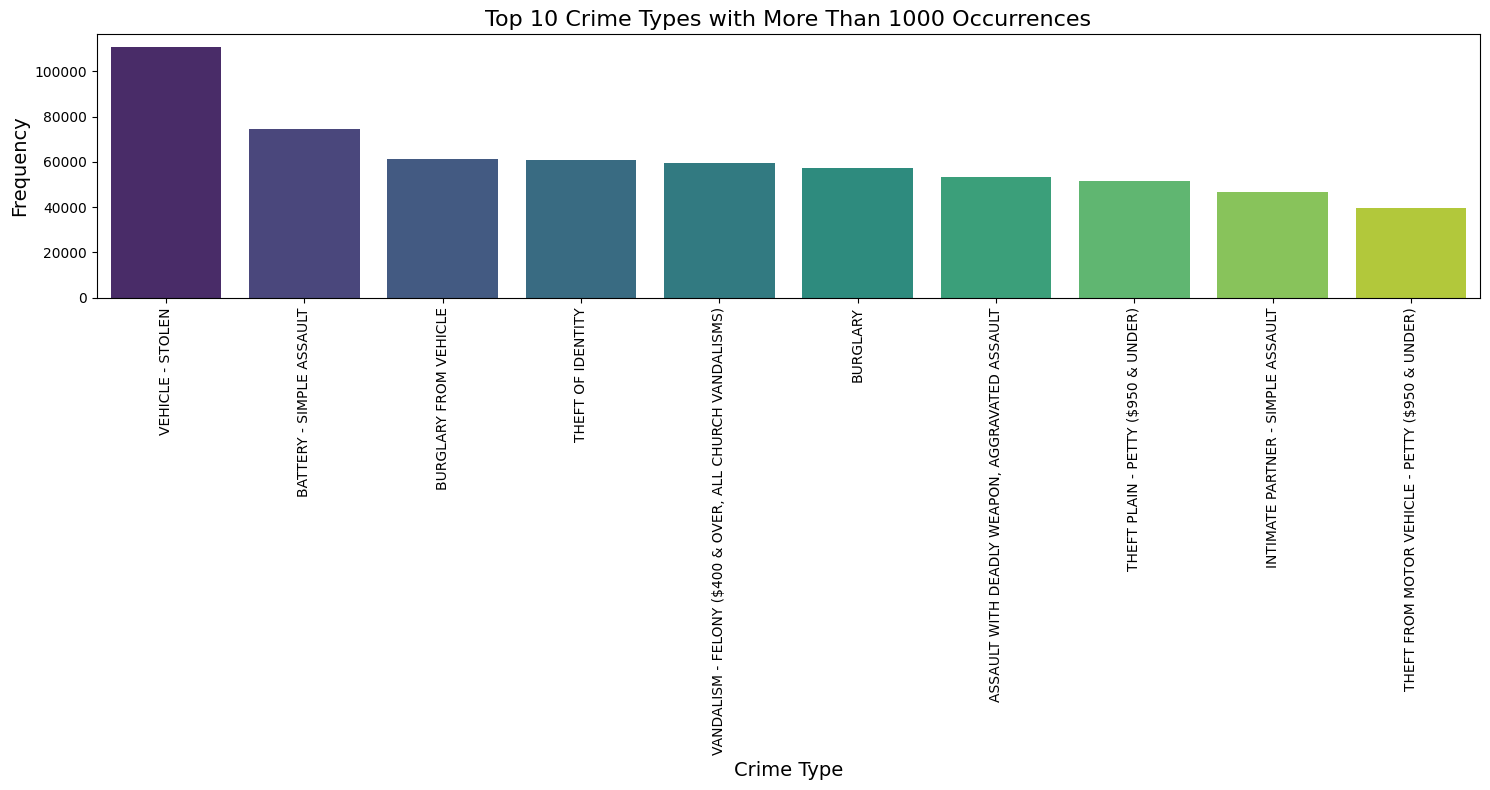

<ipython-input-48-cda56d5aba56>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_5_less_1000.index, y=top_5_less_1000.values, palette="coolwarm")


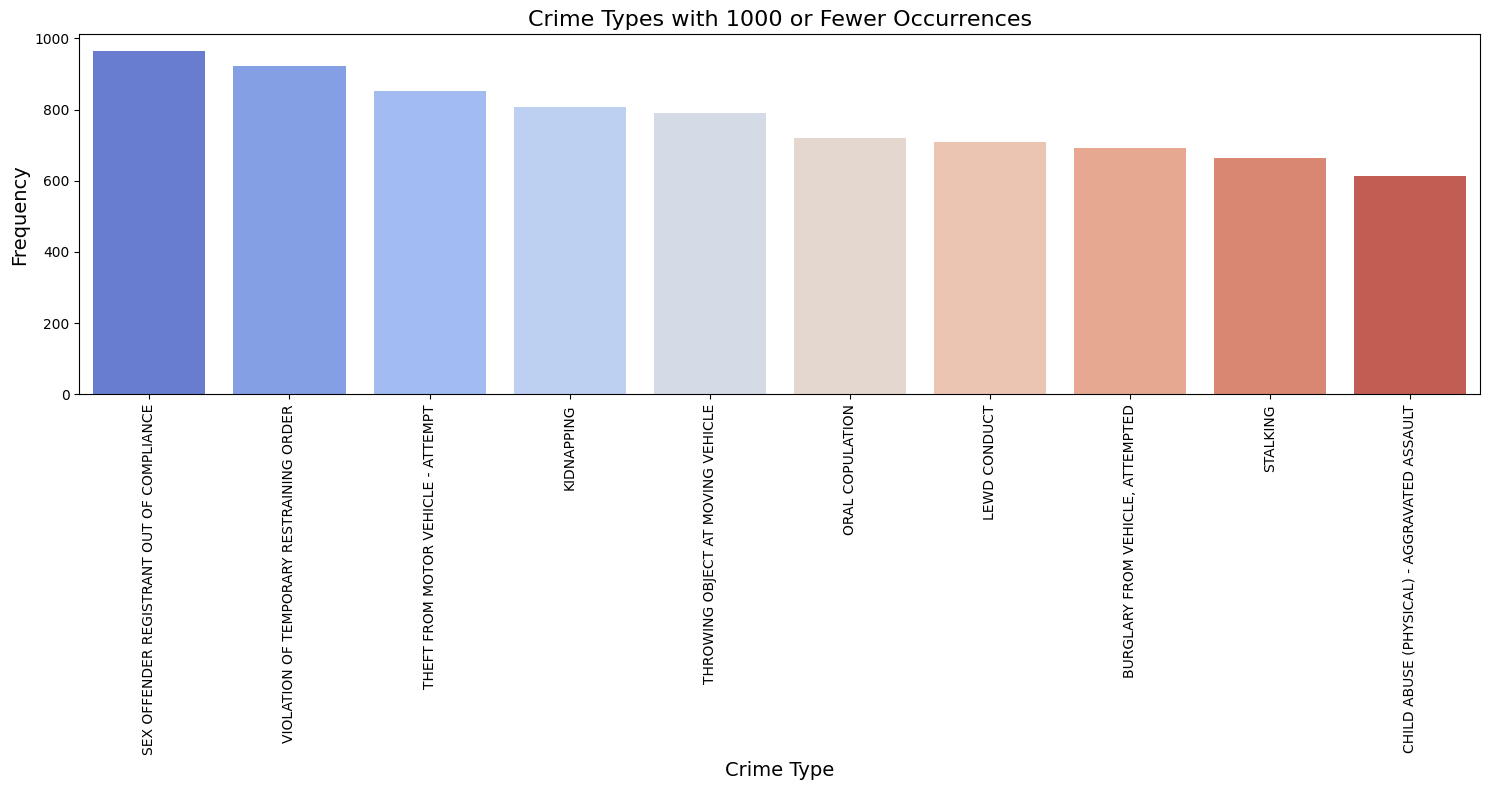

In [48]:
# Crime type counts
crime_type_counts = df['crime_code_description'].value_counts()

# Crime types with more than 1000 occurrences
more_1000_crime_type_counts = crime_type_counts[crime_type_counts > 1000]

# Select top N (for example, top 5) most frequent crime types with more than 1000 occurrences
top_5_more_1000 = more_1000_crime_type_counts.head(10)

# Crime types with 1000 or fewer occurrences
less_1000_crime_type_counts = crime_type_counts[crime_type_counts <= 1000]

# Select top N (for example, top 5) most frequent crime types with 1000 or fewer occurrences
top_5_less_1000 = less_1000_crime_type_counts.head(10)

# Plot for top 5 crime types with more than 1000 occurrences
plt.figure(figsize=(15, 8))
sns.barplot(x=top_5_more_1000.index, y=top_5_more_1000.values, palette="viridis")
plt.title("Top 10 Crime Types with More Than 1000 Occurrences", fontsize=16)
plt.xlabel("Crime Type", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Plot for crime types with 1000 or fewer occurrences (sorted for better readability)
plt.figure(figsize=(15, 8))
sns.barplot(x=top_5_less_1000.index, y=top_5_less_1000.values, palette="coolwarm")
plt.title("Crime Types with 1000 or Fewer Occurrences", fontsize=16)
plt.xlabel("Crime Type", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



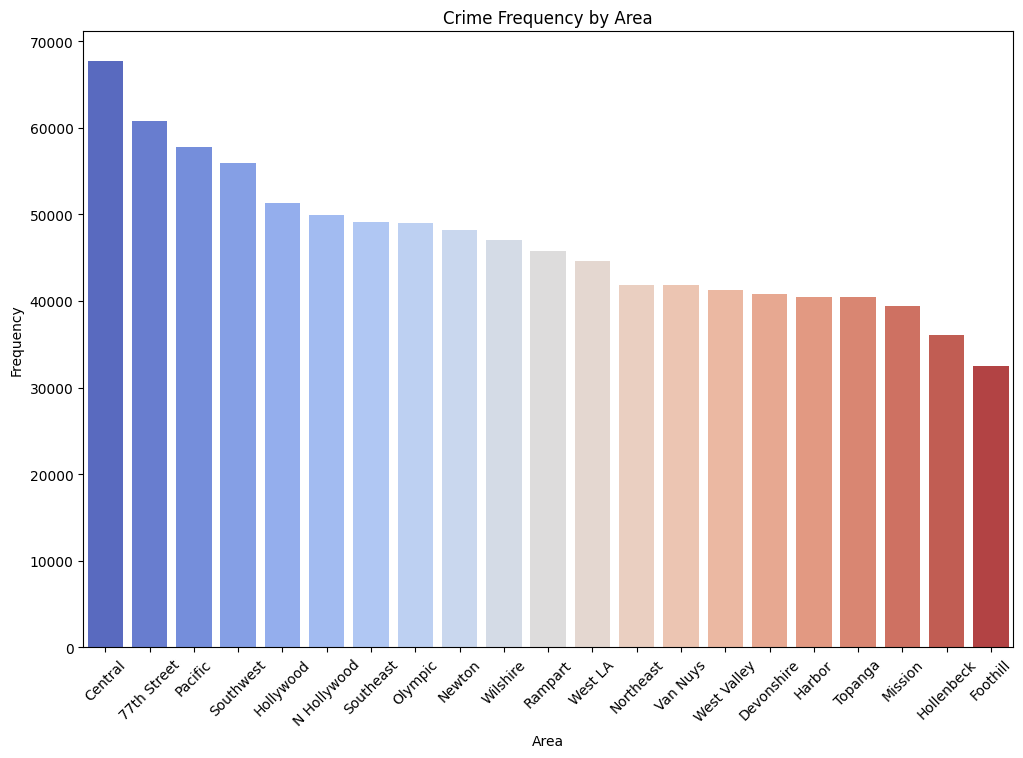

In [25]:
# Frequency of crimes by area
crime_area_counts = df['area_name'].value_counts()

# Plotting the frequency of crimes by area
plt.figure(figsize=(12, 8))
sns.barplot(x=crime_area_counts.index, y=crime_area_counts.values, palette="coolwarm", hue=crime_area_counts.index, legend=False)
plt.title("Crime Frequency by Area")
plt.xlabel("Area")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

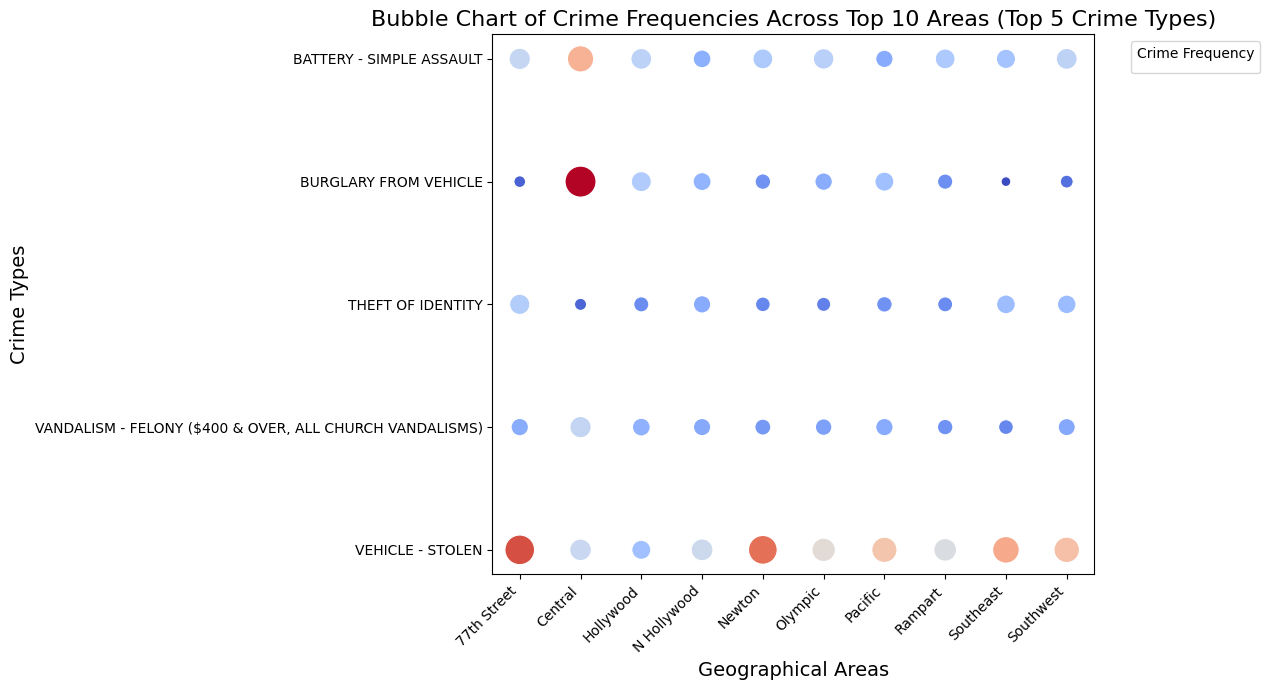

In [26]:
# Count the occurrences of each crime type per area
crime_area_freq = df.groupby(['area_name', 'crime_code_description']).size().reset_index(name='count')

# Get the top 5 most frequent crime types
top_5_crime_types = crime_area_freq.groupby('crime_code_description')['count'].sum().nlargest(5).index
filtered_data = crime_area_freq[crime_area_freq['crime_code_description'].isin(top_5_crime_types)]

# Get the top 10 areas with the most crimes
top_10_areas = filtered_data.groupby('area_name')['count'].sum().nlargest(10).index
filtered_data = filtered_data[filtered_data['area_name'].isin(top_10_areas)]

# Visualization: Bubble Chart
plt.figure(figsize=(13, 7))
sns.scatterplot(
    data=filtered_data,
    x='area_name',
    y='crime_code_description',
    size='count',
    sizes=(50, 500),  # Adjust bubble sizes
    hue='count',
    palette='coolwarm',
    legend=False  # Remove legend since we are showing crime frequency as hue
)

# Titles and labels
plt.title("Bubble Chart of Crime Frequencies Across Top 10 Areas (Top 5 Crime Types)", fontsize=16)
plt.xlabel("Geographical Areas", fontsize=14)
plt.ylabel("Crime Types", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add a custom legend for the bubble sizes
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, title="Crime Frequency", loc='upper left', bbox_to_anchor=(1.05, 1))

# Show plot
plt.tight_layout()
plt.show()


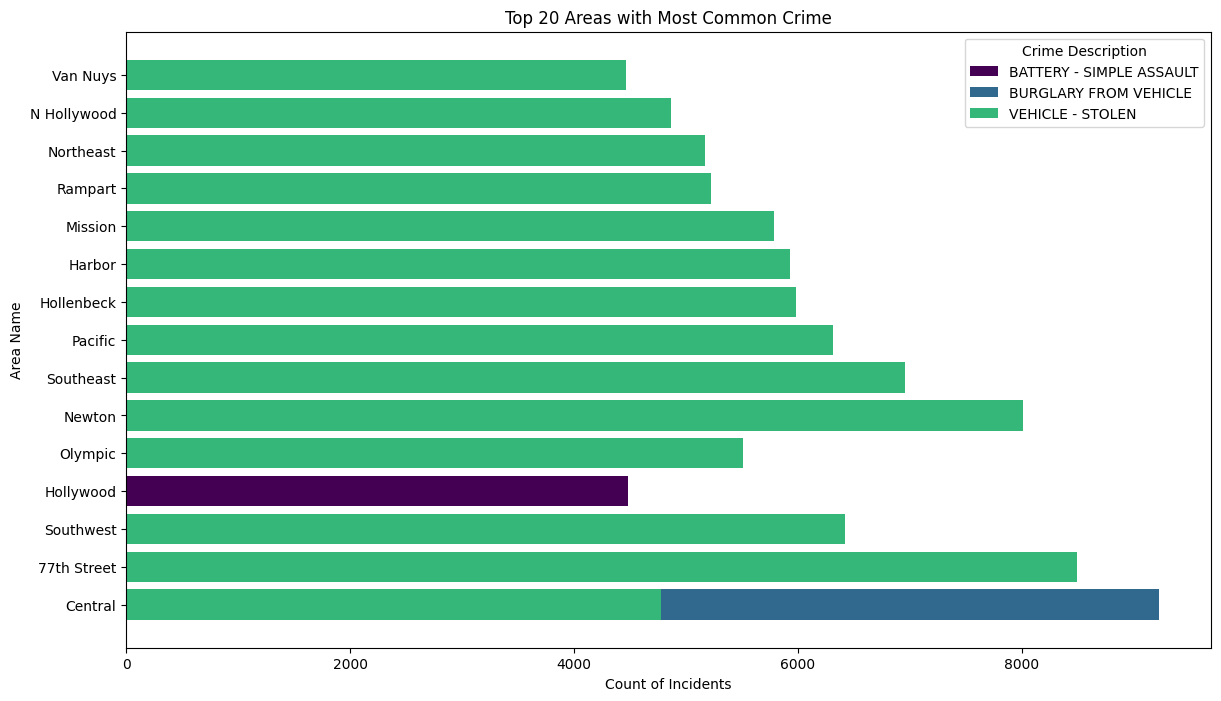

In [27]:
# Filter data based on crime types
Vehicle_stolen = df[df['crime_code_description'].str.startswith('VEHICLE - STOLEN')]
BURGLARY_FROM_VEHICLE = df[df['crime_code_description'].str.startswith('BURGLARY FROM VEHICLE')]
BATTERY_SIMPLE_ASSAULT = df[df['crime_code_description'].str.startswith('BATTERY - SIMPLE ASSAULT')]

# Concatenate the filtered datasets to focus on common crime types
common_crime = pd.concat([Vehicle_stolen, BURGLARY_FROM_VEHICLE, BATTERY_SIMPLE_ASSAULT])

# Group by crime description and area name, and sort by the count of incidents
common_area_crime = common_crime.groupby(['crime_code_description', 'area_name']).size().reset_index(name='Count').sort_values('Count', ascending=False).head(20)

# Create the bar plot using matplotlib's inbuilt color cycle
plt.figure(figsize=(14, 8))

# Plot the bar chart without specifying hue, and use matplotlib's color cycle
for idx, (crime_desc, data) in enumerate(common_area_crime.groupby('crime_code_description')):
    plt.barh(data['area_name'], data['Count'], label=crime_desc, color=plt.cm.viridis(idx / len(common_area_crime['crime_code_description'].unique())))

# Set the title, labels, and legend
plt.title('Top 20 Areas with Most Common Crime')
plt.xlabel('Count of Incidents')
plt.ylabel('Area Name')
plt.legend(title='Crime Description', loc='upper right')

# Display the plot
plt.show()

# ** QUE 2**  Is there a correlation between the time of day and specific crime types ?

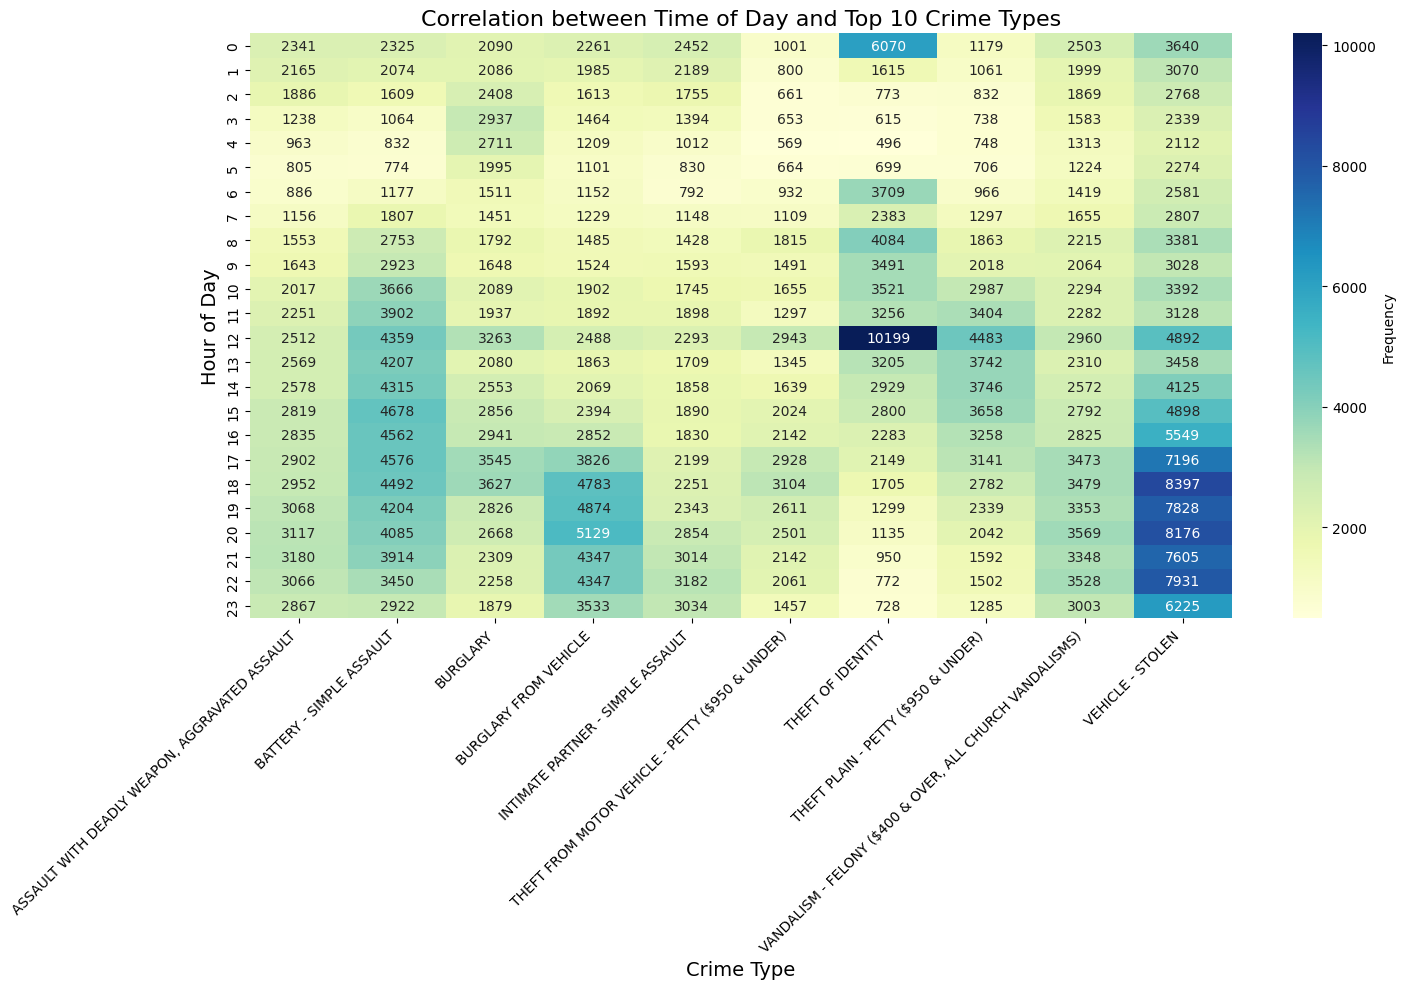

In [28]:
# Extract hour of the day from time_occurred
df['hour_occurred'] = pd.to_datetime(df['time_occurred'], format='%H:%M:%S', errors='coerce').dt.hour

# Get the top 10 most frequent crime types
top_10_crime_types = df['crime_code_description'].value_counts().head(10).index

# Filter the dataframe to include only the top 10 crime types
filtered_df = df[df['crime_code_description'].isin(top_10_crime_types)]

# Create a crosstab for hour of the day vs crime type
time_crime_corr = pd.crosstab(filtered_df['hour_occurred'], filtered_df['crime_code_description'])

# Heatmap for correlation between time of day and crime types
plt.figure(figsize=(15, 10))
sns.heatmap(time_crime_corr, annot=True, cmap="YlGnBu", fmt="d", cbar_kws={'label': 'Frequency'})
plt.title("Correlation between Time of Day and Top 10 Crime Types", fontsize=16)
plt.xlabel("Crime Type", fontsize=14)
plt.ylabel("Hour of Day", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Ensures that labels do not overlap
plt.show()


# QUE3 : How does the age and gender of Victims (Vict Age, Vict Sex) vary across different crime categories?

In [29]:
# Group by crime type and victim sex, then calculate the average victim age
age_gender_crime_type = df.groupby(['crime_code_description', 'victim_sex'])['victim_age'].mean().reset_index()

# Check for missing or NaN values and remove them
age_gender_crime_type = age_gender_crime_type.dropna()

# Separate the data for male and female victims
male_data = age_gender_crime_type[age_gender_crime_type['victim_sex'] == 'M']
female_data = age_gender_crime_type[age_gender_crime_type['victim_sex'] == 'F']



<ipython-input-30-6d09afb90140>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=male_data, x='victim_age', kde=True, multiple="stack", palette='Blues')


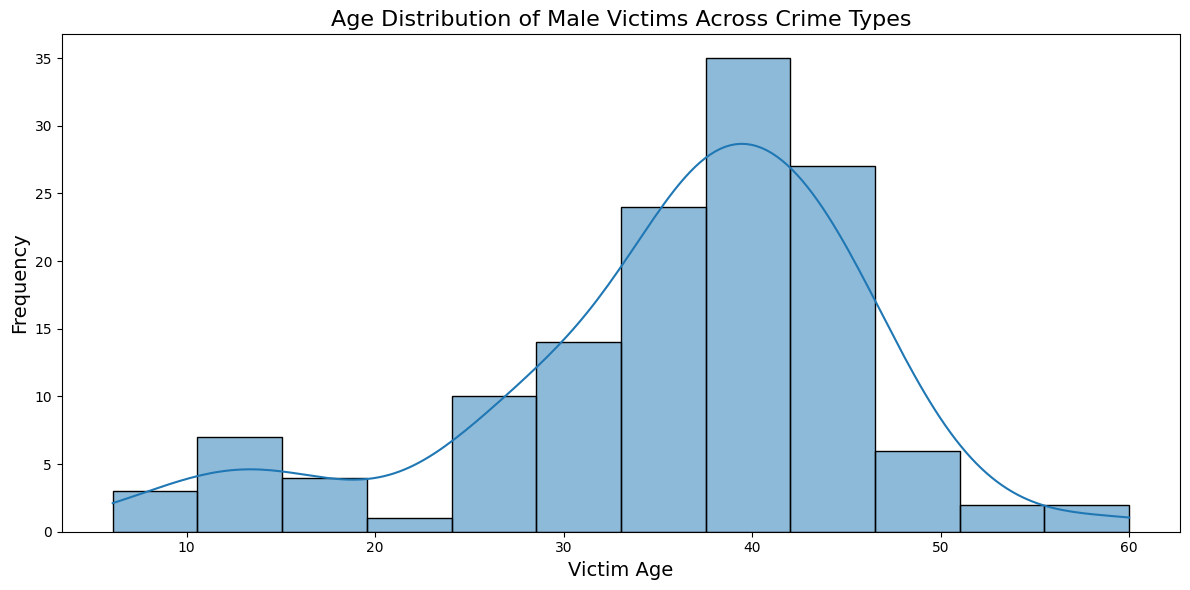

<ipython-input-30-6d09afb90140>:12: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=female_data, x='victim_age', kde=True, multiple="stack", palette='Reds')


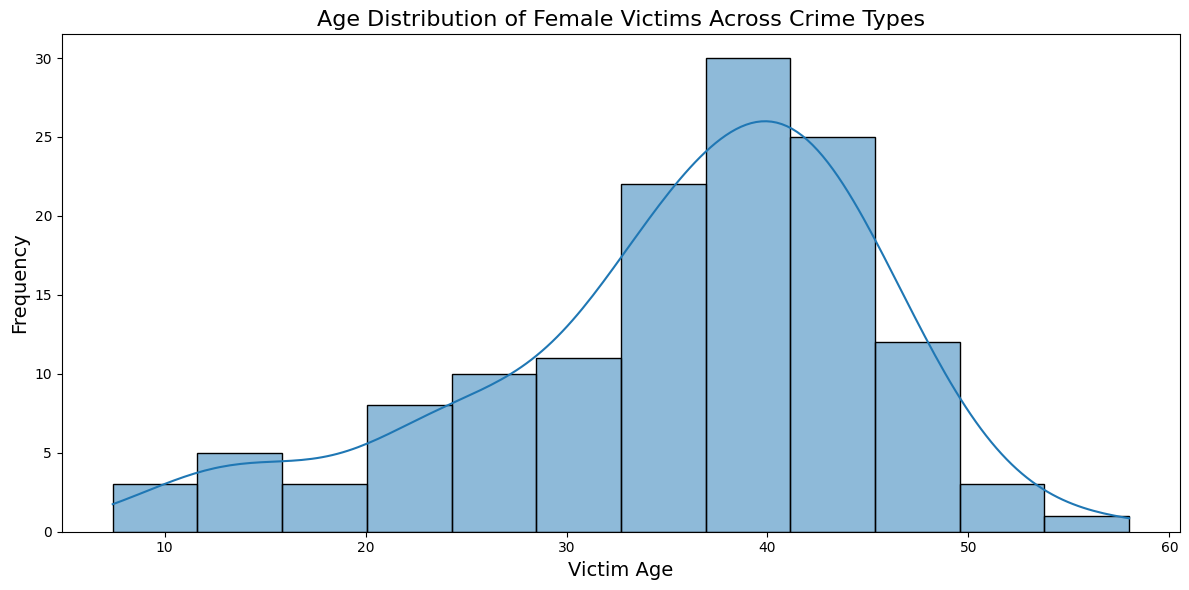

In [30]:
# Histogram for Male Victims (Age Distribution Across Crime Types)
plt.figure(figsize=(12, 6))
sns.histplot(data=male_data, x='victim_age', kde=True, multiple="stack", palette='Blues')
plt.title('Age Distribution of Male Victims Across Crime Types', fontsize=16)
plt.xlabel('Victim Age', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.tight_layout()
plt.show()

# Histogram for Female Victims (Age Distribution Across Crime Types)
plt.figure(figsize=(12, 6))
sns.histplot(data=female_data, x='victim_age', kde=True, multiple="stack", palette='Reds')
plt.title('Age Distribution of Female Victims Across Crime Types', fontsize=16)
plt.xlabel('Victim Age', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.tight_layout()
plt.show()


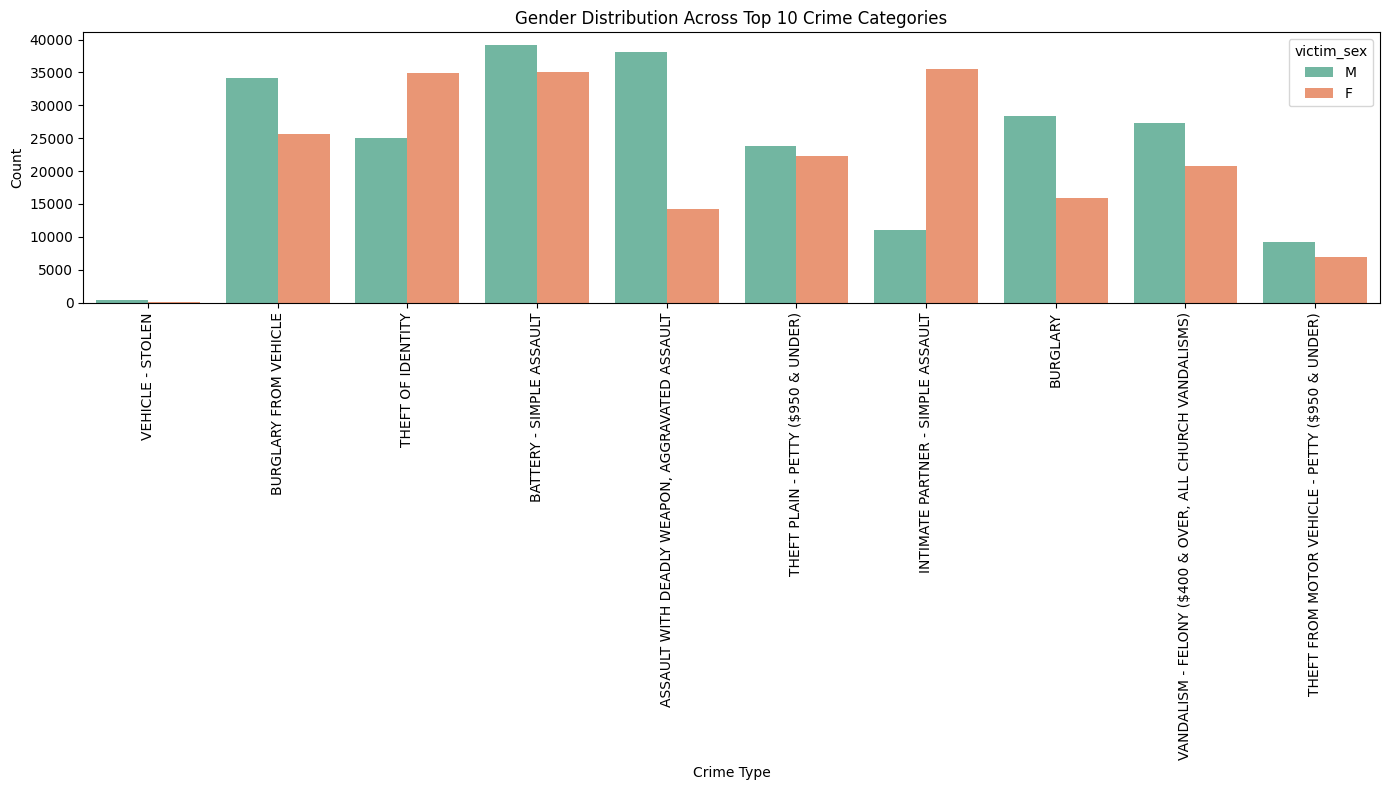

In [31]:
# Filter top 10 most frequent crime types based on 'crime_code_description'
top_crimes = df['crime_code_description'].value_counts().head(10).index
filtered_data = df[df['crime_code_description'].isin(top_crimes)]

# Drop rows with missing age or sex data
filtered_data = filtered_data.dropna(subset=['victim_age', 'victim_sex'])

# Countplot for gender distribution of the top 10 crimes
plt.figure(figsize=(14, 8))
sns.countplot(data=filtered_data, x='crime_code_description', hue='victim_sex', palette='Set2')
plt.title('Gender Distribution Across Top 10 Crime Categories')
plt.xlabel('Crime Type')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# Que4 : What trends can be observed in the use of weapons (WeaponUsed Cd, Weapon Desc) for various crime types over the given time period?

In [32]:
# Ensure 'date_occurred' is in datetime format
df['date_occurred'] = pd.to_datetime(df['date_occurred'], errors='coerce')

# Extract the year from the 'date_occurred' column
df['year_occurred'] = df['date_occurred'].dt.year

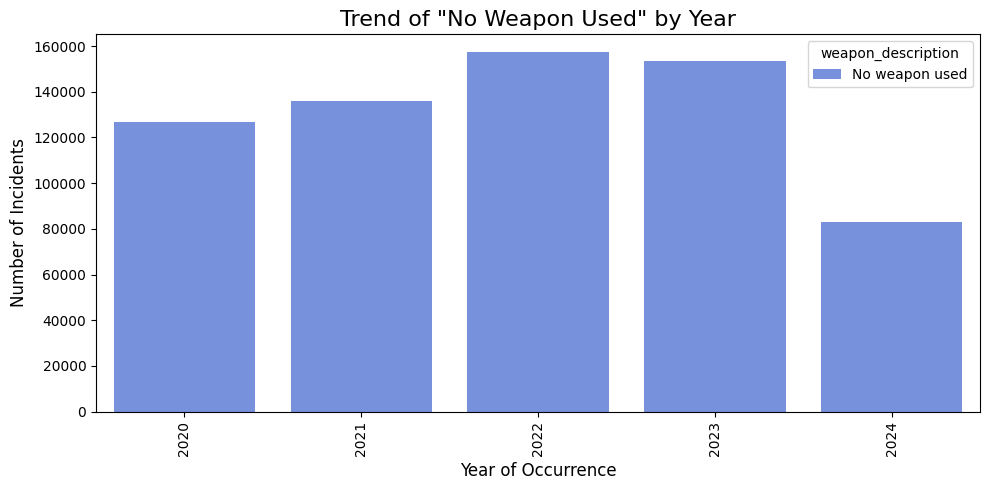

In [33]:

df_filtered = df[['weapon_code', 'weapon_description', 'crime_code_description', 'year_occurred']]
df_filtered = df_filtered.dropna(subset=['weapon_code', 'year_occurred'])

df_filtered['weapon_code'] = df_filtered['weapon_code'].astype(str)

# Spliting the data into 'No weapon used' and other weapon categories for better visualization
no_weapon_used = df_filtered[df_filtered['weapon_description'] == 'No weapon used']
no_weapon_used_trends = no_weapon_used.groupby(['year_occurred', 'weapon_description']).size().reset_index(name='count')

sns.set_palette("coolwarm")

# 'No weapon used' plot
plt.figure(figsize=(10, 5))
sns.barplot(data=no_weapon_used_trends, x='year_occurred', y='count', hue='weapon_description', errorbar=None)
plt.title('Trend of "No Weapon Used" by Year', fontsize=16)
plt.xlabel('Year of Occurrence', fontsize=12)
plt.ylabel('Number of Incidents', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [34]:
# weapon-code table
weapon_table = df_filtered.groupby(['weapon_code', 'weapon_description']).size().reset_index(name='count')
weapon_table = weapon_table.drop(columns=['count'])
weapon_table = weapon_table.sort_values('weapon_code')

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(weapon_table.to_string(index=False))

weapon_code                             weapon_description
        0.0                                 No weapon used
      101.0                                       REVOLVER
      102.0                                       HAND GUN
      103.0                                          RIFLE
      104.0                                        SHOTGUN
      105.0                        SAWED OFF RIFLE/SHOTGUN
      106.0                                UNKNOWN FIREARM
      107.0                                  OTHER FIREARM
      108.0               AUTOMATIC WEAPON/SUB-MACHINE GUN
      109.0                          SEMI-AUTOMATIC PISTOL
      110.0                           SEMI-AUTOMATIC RIFLE
      111.0                        STARTER PISTOL/REVOLVER
      112.0                                        TOY GUN
      113.0                                  SIMULATED GUN
      114.0               AIR PISTOL/REVOLVER/RIFLE/BB GUN
      115.0                    ASSAULT WEAPON/UZI/AK47/E

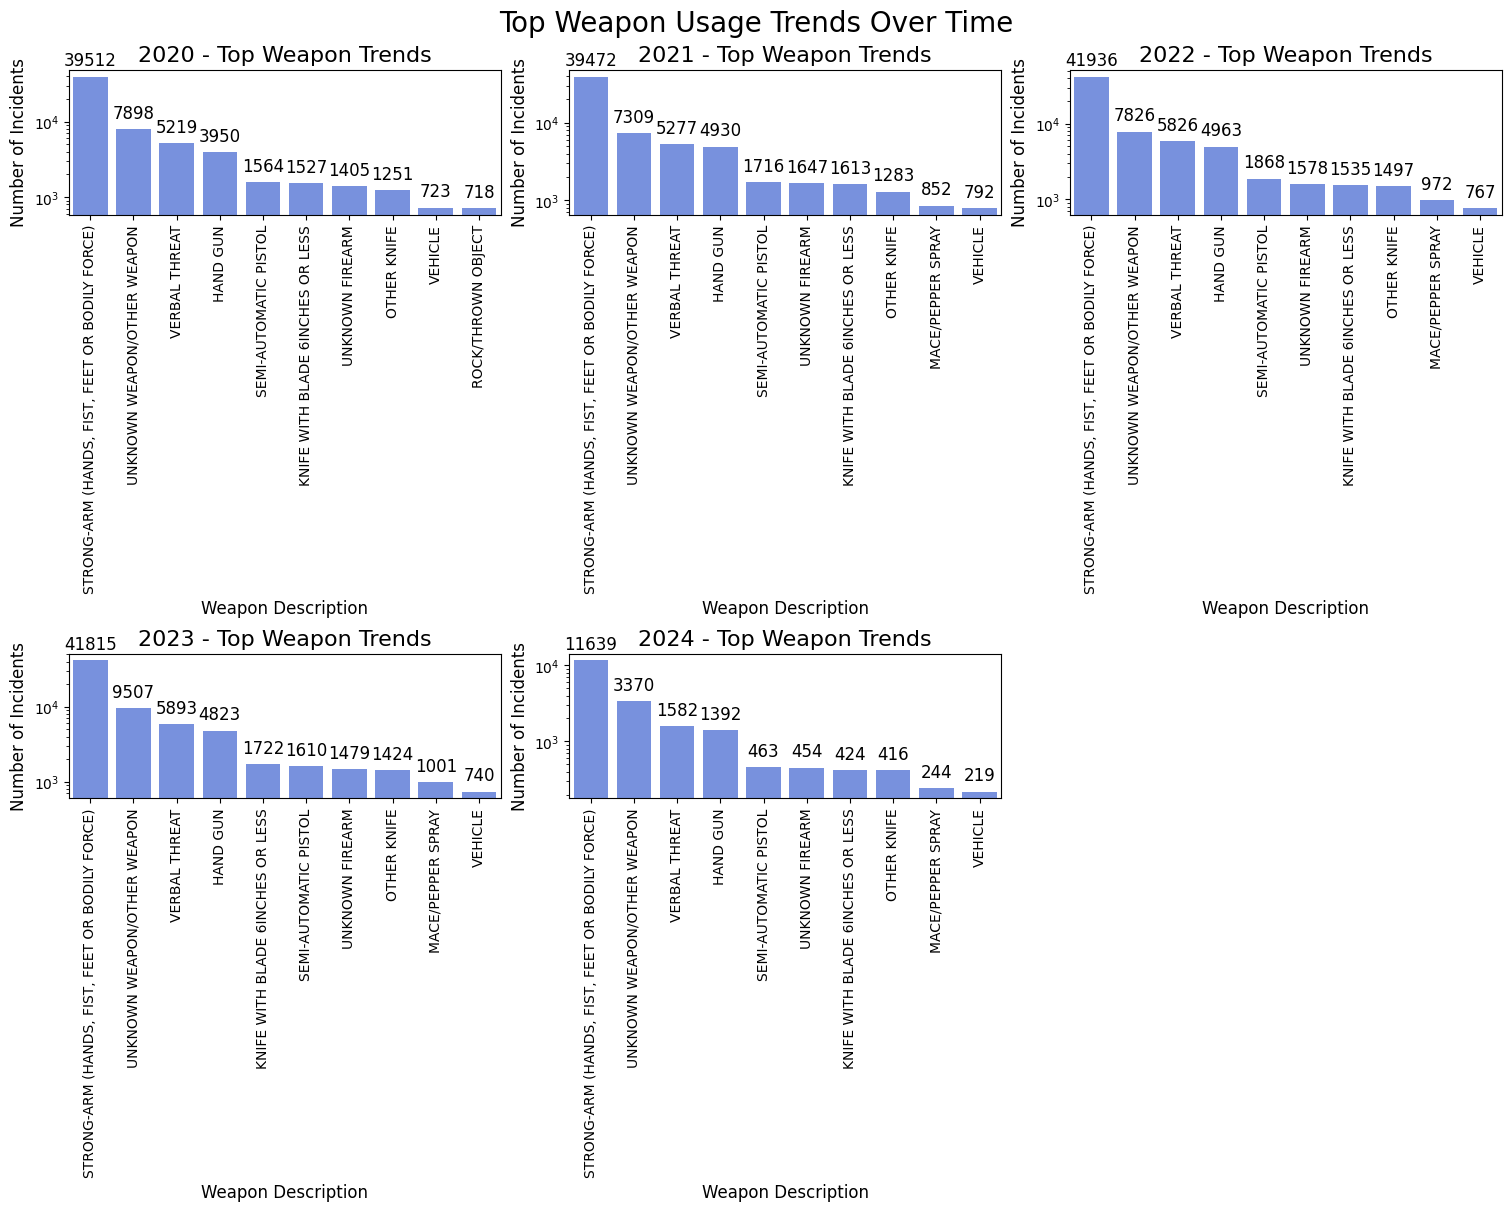

In [35]:
# Filter out 'No weapon used' records
other_weapons = df_filtered[df_filtered['weapon_description'] != 'No weapon used']

# Group the data by 'year_occurred' and 'weapon_code'
other_weapons_trends = other_weapons.groupby(['year_occurred', 'weapon_code', 'weapon_description']).size().reset_index(name='count')

# Sort by count within each year to get the most frequent weapon types
other_weapons_trends = other_weapons_trends.sort_values(['year_occurred', 'count'], ascending=[True, False])

# Limit the number of weapon types to show for each year (e.g., top 10 most frequent)
top_n = 10
other_weapons_trends_limited = other_weapons_trends.groupby('year_occurred').head(top_n)

# Set up the figure with a grid for vertical bar plots
num_years = len(other_weapons_trends_limited['year_occurred'].unique())
fig, axes = plt.subplots(nrows=(num_years // 3) + 1, ncols=3, figsize=(15, (num_years // 3 + 1) * 6), constrained_layout=True)

axes = axes.flatten()

# Plot data for each year using vertical bar plots
for i, year in enumerate(other_weapons_trends_limited['year_occurred'].unique()):
    year_data = other_weapons_trends_limited[other_weapons_trends_limited['year_occurred'] == year]

    ax = axes[i]
    sns.barplot(data=year_data, x='weapon_description', y='count', ax=ax, errorbar=None)
    ax.set_title(f'{year} - Top Weapon Trends', fontsize=16)
    ax.set_xlabel('Weapon Description', fontsize=12)
    ax.set_ylabel('Number of Incidents', fontsize=12)
    ax.tick_params(axis='x', rotation=90)
    ax.set_yscale('log')  # Use logarithmic scale for better readability

    # Annotate the bars with counts
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=12, color='black', rotation=0,
                    xytext=(0, 5), textcoords='offset points')

# Hide any unused subplots (in case there are fewer years than the total number of subplots)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle("Top Weapon Usage Trends Over Time", fontsize=20)
plt.show()

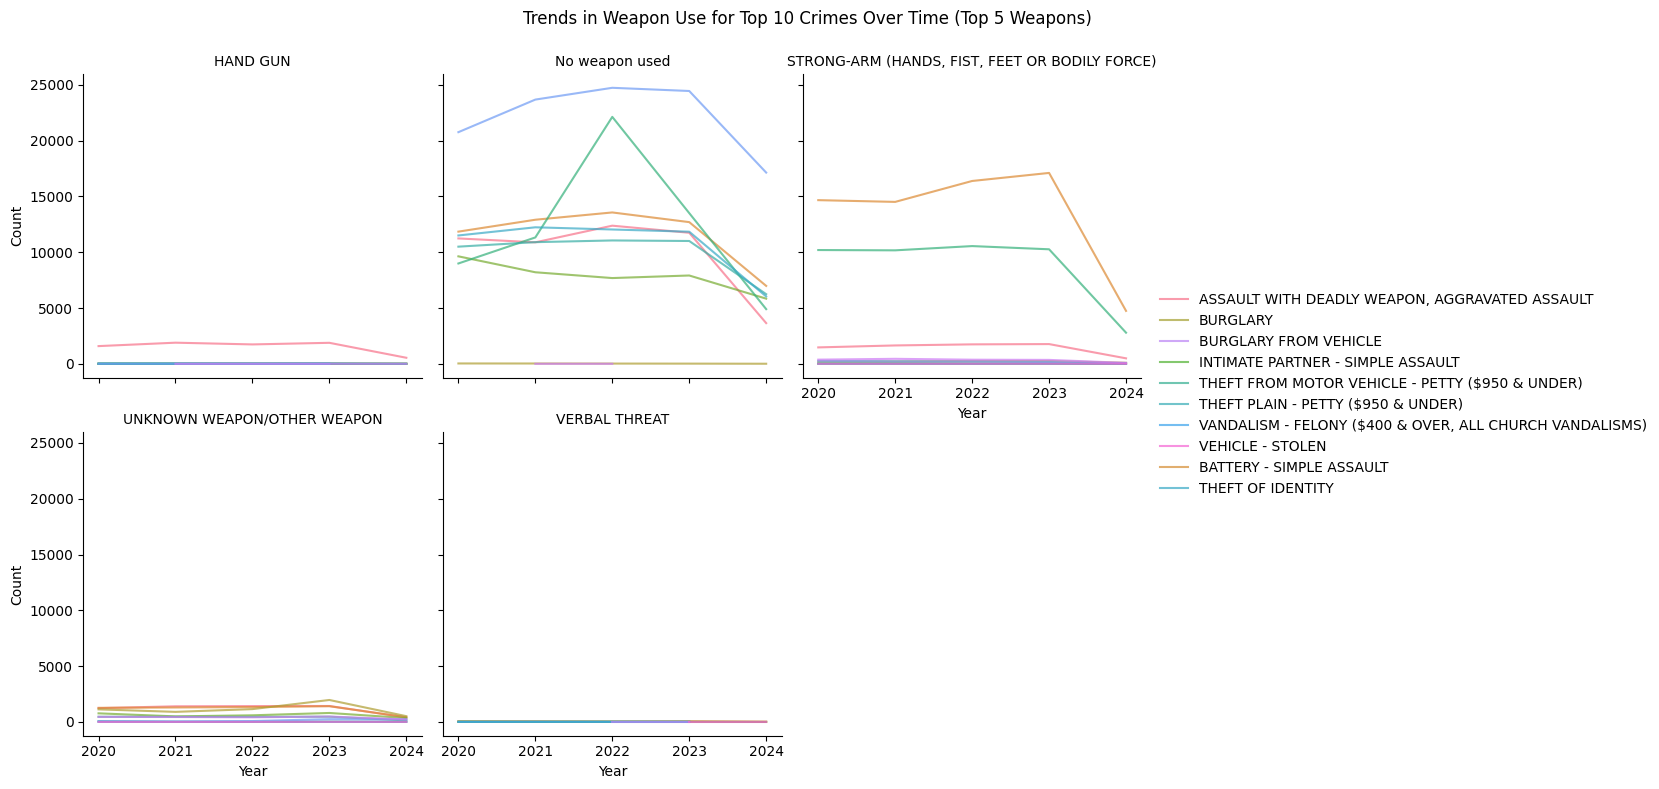

In [36]:
# Extract year and month for time-based analysis
df['year'] = df['date_occurred'].dt.year
df['month'] = df['date_occurred'].dt.month

# Group by weapon and crime type
weapon_trends = df.groupby(['year', 'weapon_description', 'crime_code_description']).size().reset_index(name='count')

# Filter for top 5 weapons based on the frequency of use
top_weapons = df['weapon_description'].value_counts().head(5).index
filtered_data = weapon_trends[weapon_trends['weapon_description'].isin(top_weapons)]

# Filter for top 10 crimes based on total occurrences
top_crimes = df['crime_code_description'].value_counts().head(10).index
filtered_data = filtered_data[filtered_data['crime_code_description'].isin(top_crimes)]

# Create FacetGrid for each weapon
g = sns.FacetGrid(filtered_data, col='weapon_description', col_wrap=3, height=4, sharey=True)
g.map(sns.lineplot, 'year', 'count', 'crime_code_description', alpha=0.7)
g.add_legend()
g.set_titles("{col_name}")
g.set_axis_labels("Year", "Count")

# Adjust layout for better presentation
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Trends in Weapon Use for Top 10 Crimes Over Time (Top 5 Weapons)")

# Show the plot
plt.show()

<Figure size 1400x800 with 0 Axes>

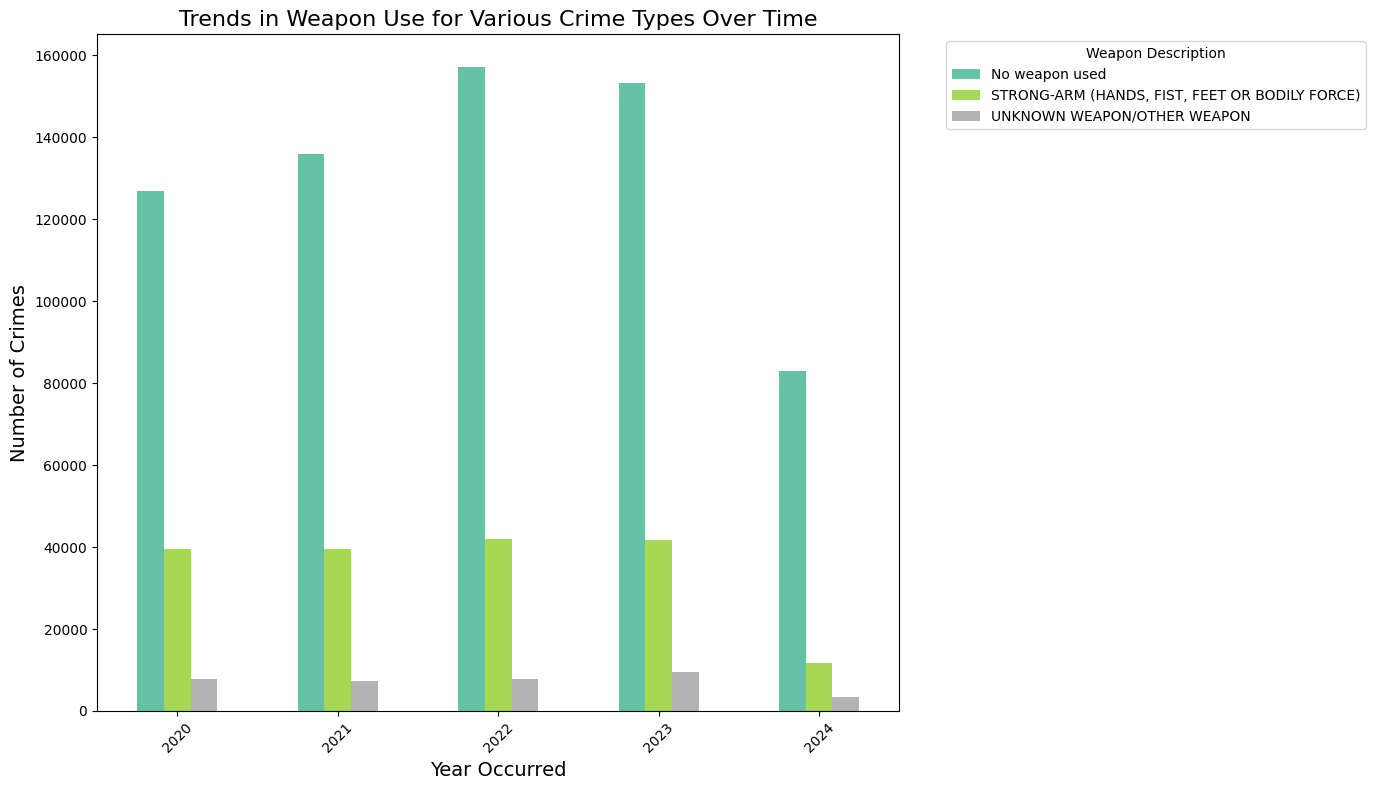

In [37]:
# Get the top 3 most common weapons used in crimes
top_weapons = df['weapon_code'].value_counts().head(3).index

# Filter the data to include only the top 3 weapons
filtered_data = df[df['weapon_code'].isin(top_weapons)]

# Group by year and weapon, count occurrences
weapon_usage_by_year = filtered_data.groupby(['year_occurred', 'weapon_description']).size().unstack(fill_value=0)

# Plotting the weapon usage trends over time
plt.figure(figsize=(14, 8))

# Use a bar plot to show the trends for each weapon
weapon_usage_by_year.plot(kind='bar', stacked=False, figsize=(14, 8), colormap='Set2')

# Add titles and labels
plt.title('Trends in Weapon Use for Various Crime Types Over Time', fontsize=16)
plt.xlabel('Year Occurred', fontsize=14)
plt.ylabel('Number of Crimes', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Weapon Description', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

# QUE 5 :Are there any noticeable patterns in crime reporting (Date Rptd) versus the actual occurrence of crimes (DATE OCC), and how might this impact crime statistics analysis?

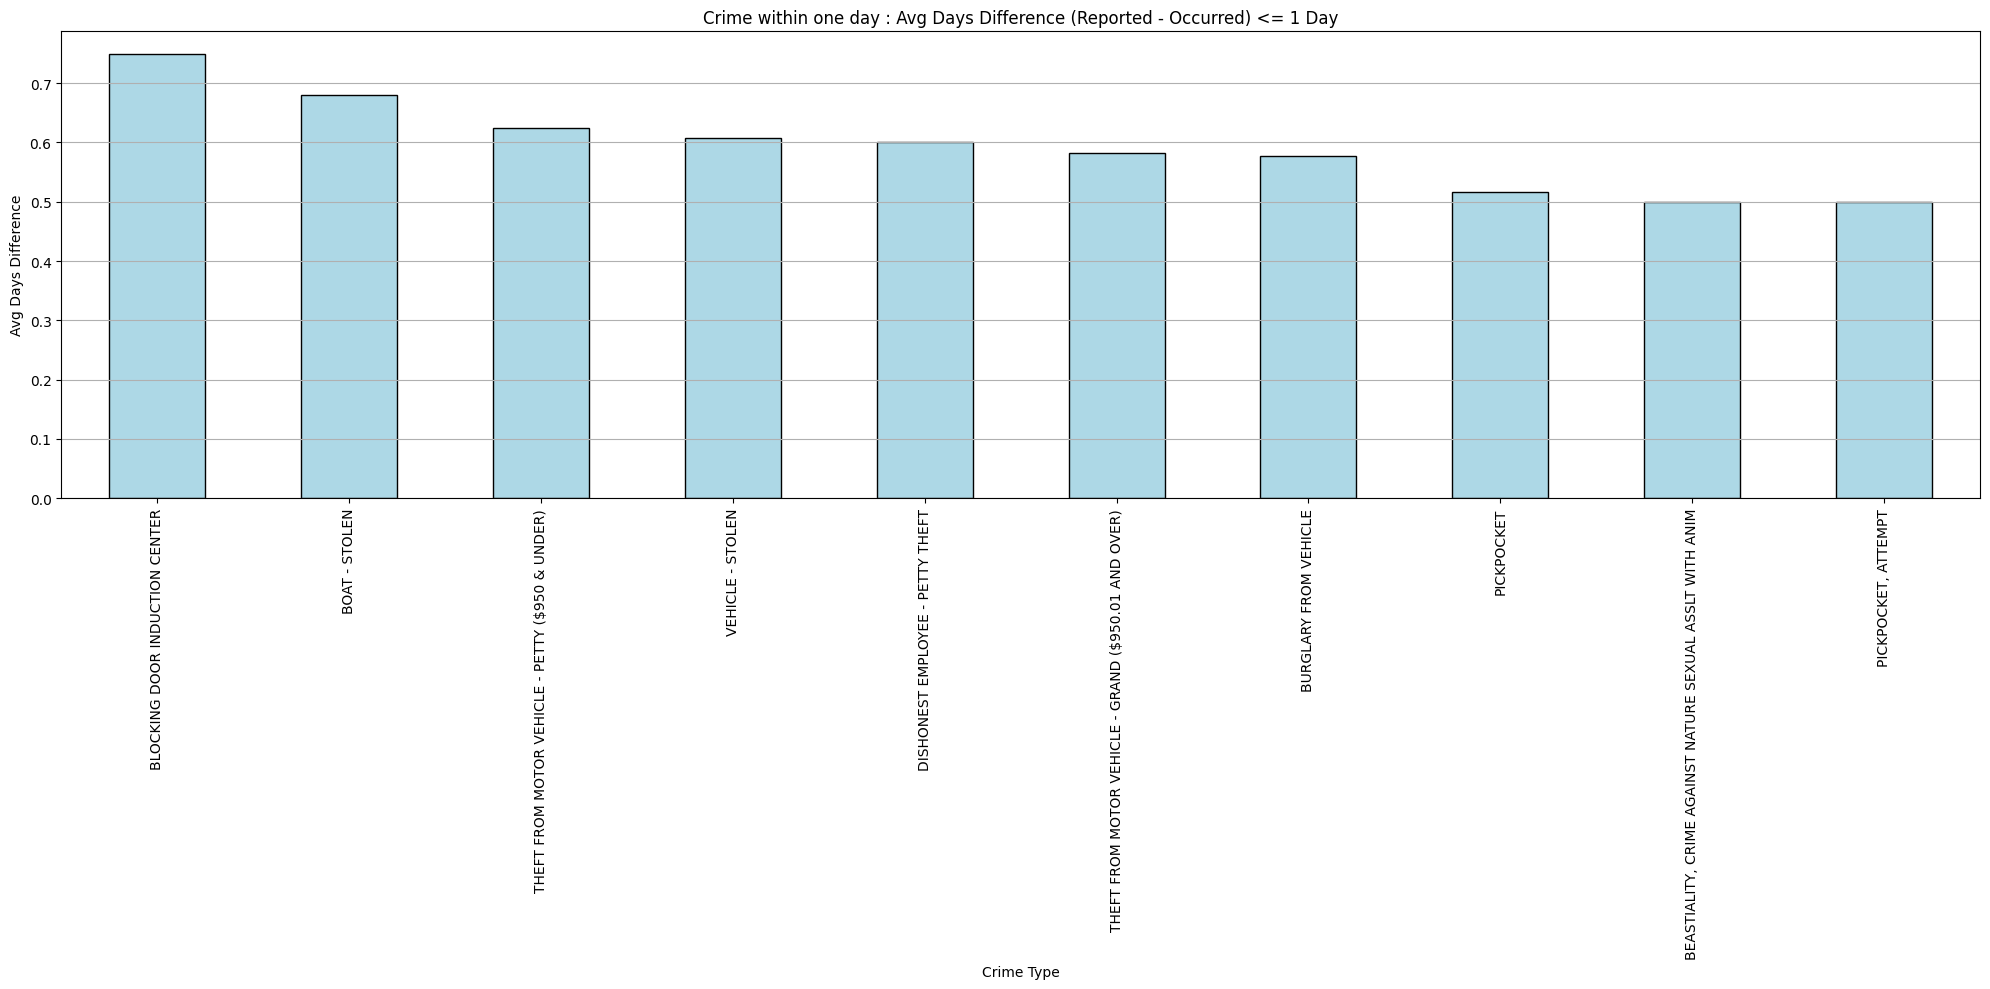

In [38]:
df['dt_reported'] = pd.to_datetime(df['date_reported'], errors='coerce')
df['date_diff'] = (df['dt_reported'] - df['date_occurred']).dt.days

#spliting for better visual presentation
df_under_1 = df[df['date_diff'] <= 1]
crime_diff_under_1 = df_under_1.groupby('crime_code_description')['date_diff'].mean().sort_values()

crime_diff_under_1=crime_diff_under_1.nlargest(10)

plt.figure(figsize=(20, 10))
crime_diff_under_1.plot(kind='bar', color='lightblue', edgecolor='black')
plt.title('Crime within one day : Avg Days Difference (Reported - Occurred) <= 1 Day')
plt.xlabel('Crime Type')
plt.ylabel('Avg Days Difference')
plt.xticks(rotation=90)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


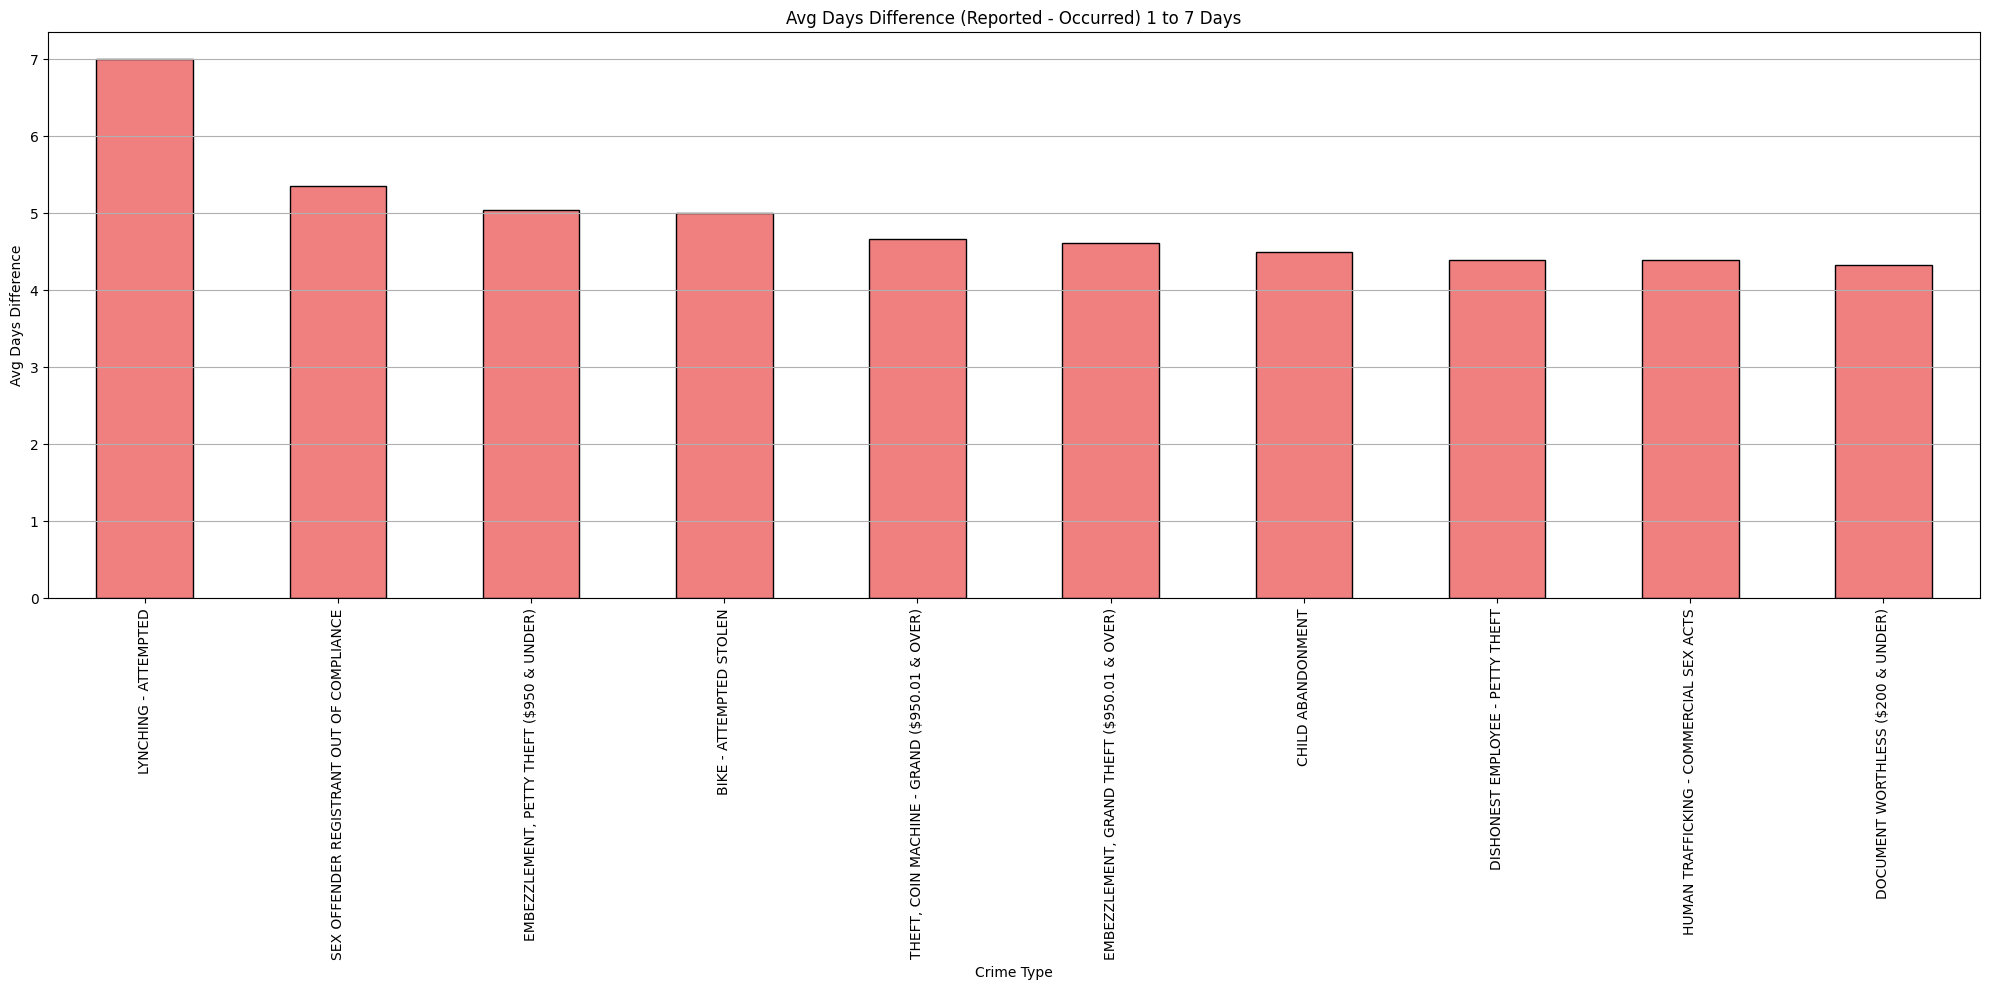

In [39]:
df_between_1_7 = df[(df['date_diff'] > 1) & (df['date_diff'] <= 7)]
crime_diff_between_1_7 = df_between_1_7.groupby('crime_code_description')['date_diff'].mean().sort_values()

crime_diff_between_1_7=crime_diff_between_1_7.nlargest(10)

plt.figure(figsize=(20, 10))
crime_diff_between_1_7.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title('Avg Days Difference (Reported - Occurred) 1 to 7 Days')
plt.xlabel('Crime Type')
plt.ylabel('Avg Days Difference')
plt.xticks(rotation=90)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

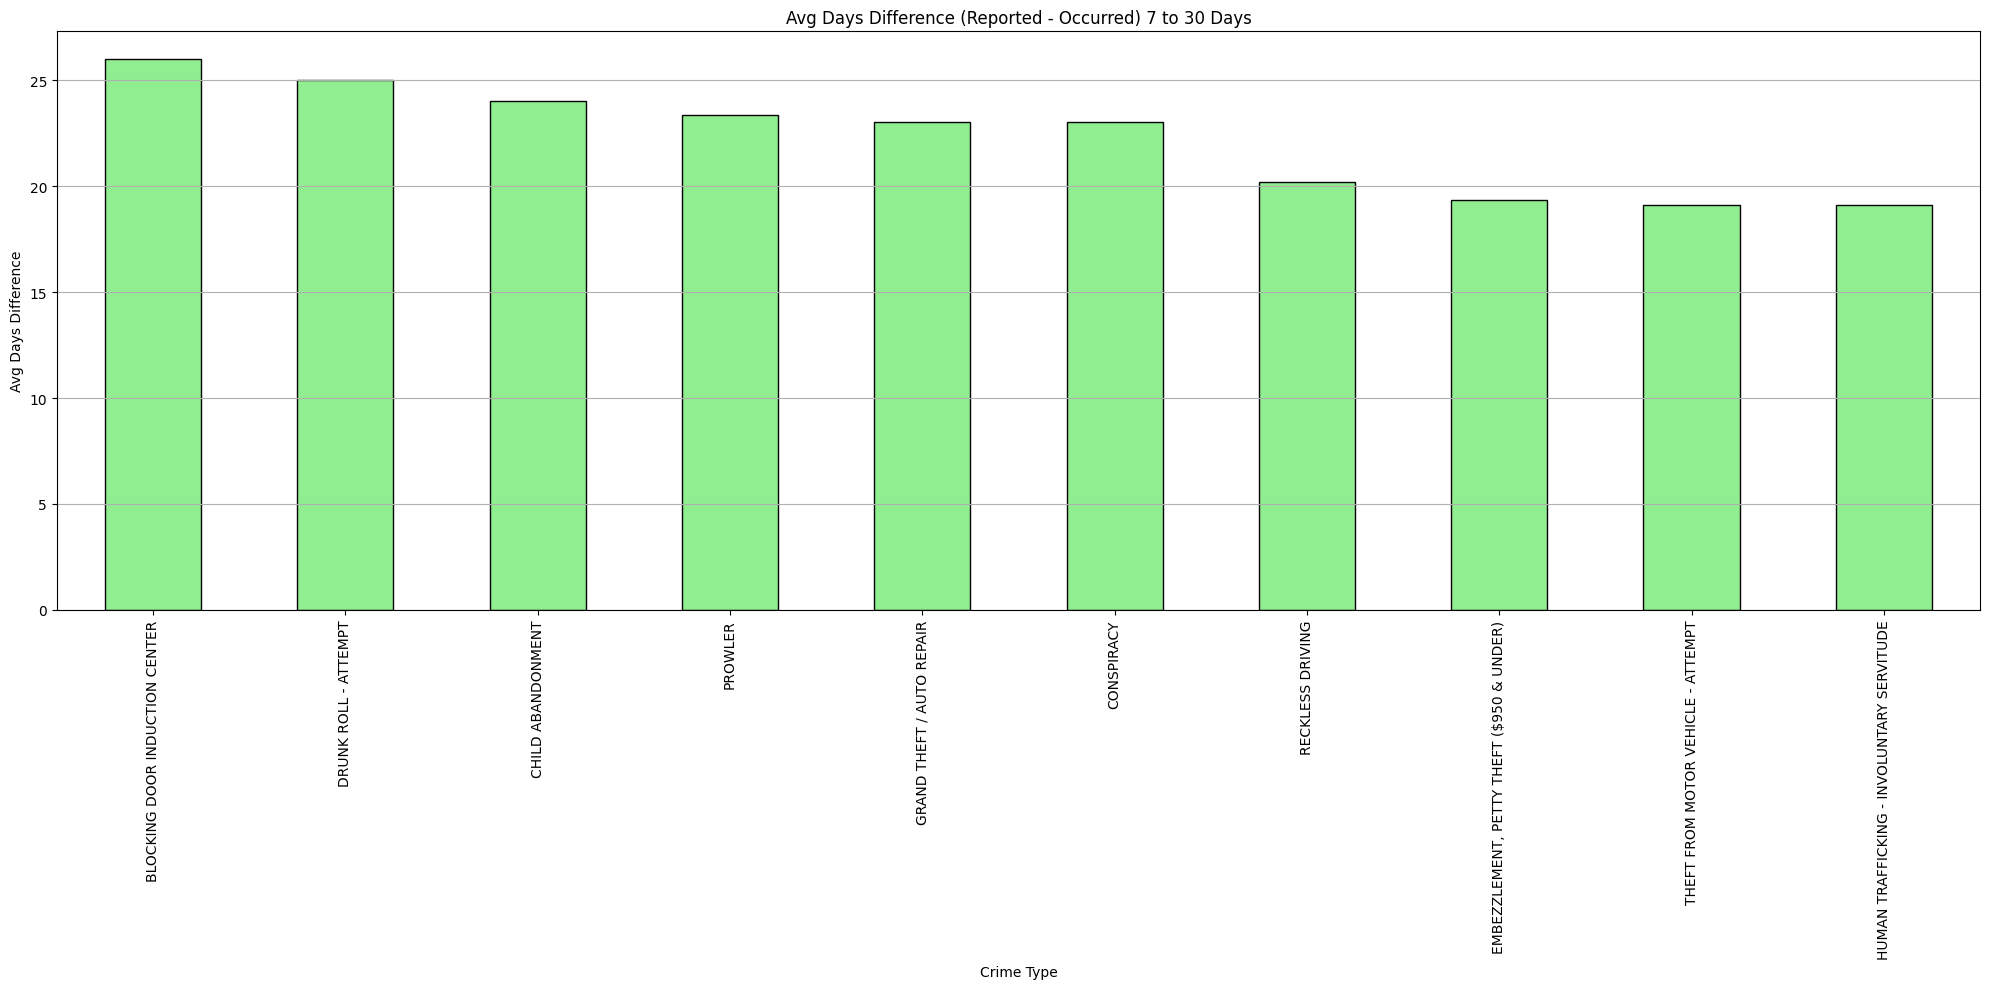

In [40]:
df_between_7_30 = df[(df['date_diff'] > 7) & (df['date_diff'] <= 30)]
crime_diff_between_7_30 = df_between_7_30.groupby('crime_code_description')['date_diff'].mean().sort_values()

crime_diff_between_7_30=crime_diff_between_7_30.nlargest(10)
plt.figure(figsize=(20, 10))
crime_diff_between_7_30.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Avg Days Difference (Reported - Occurred) 7 to 30 Days')
plt.xlabel('Crime Type')
plt.ylabel('Avg Days Difference')
plt.xticks(rotation=90)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

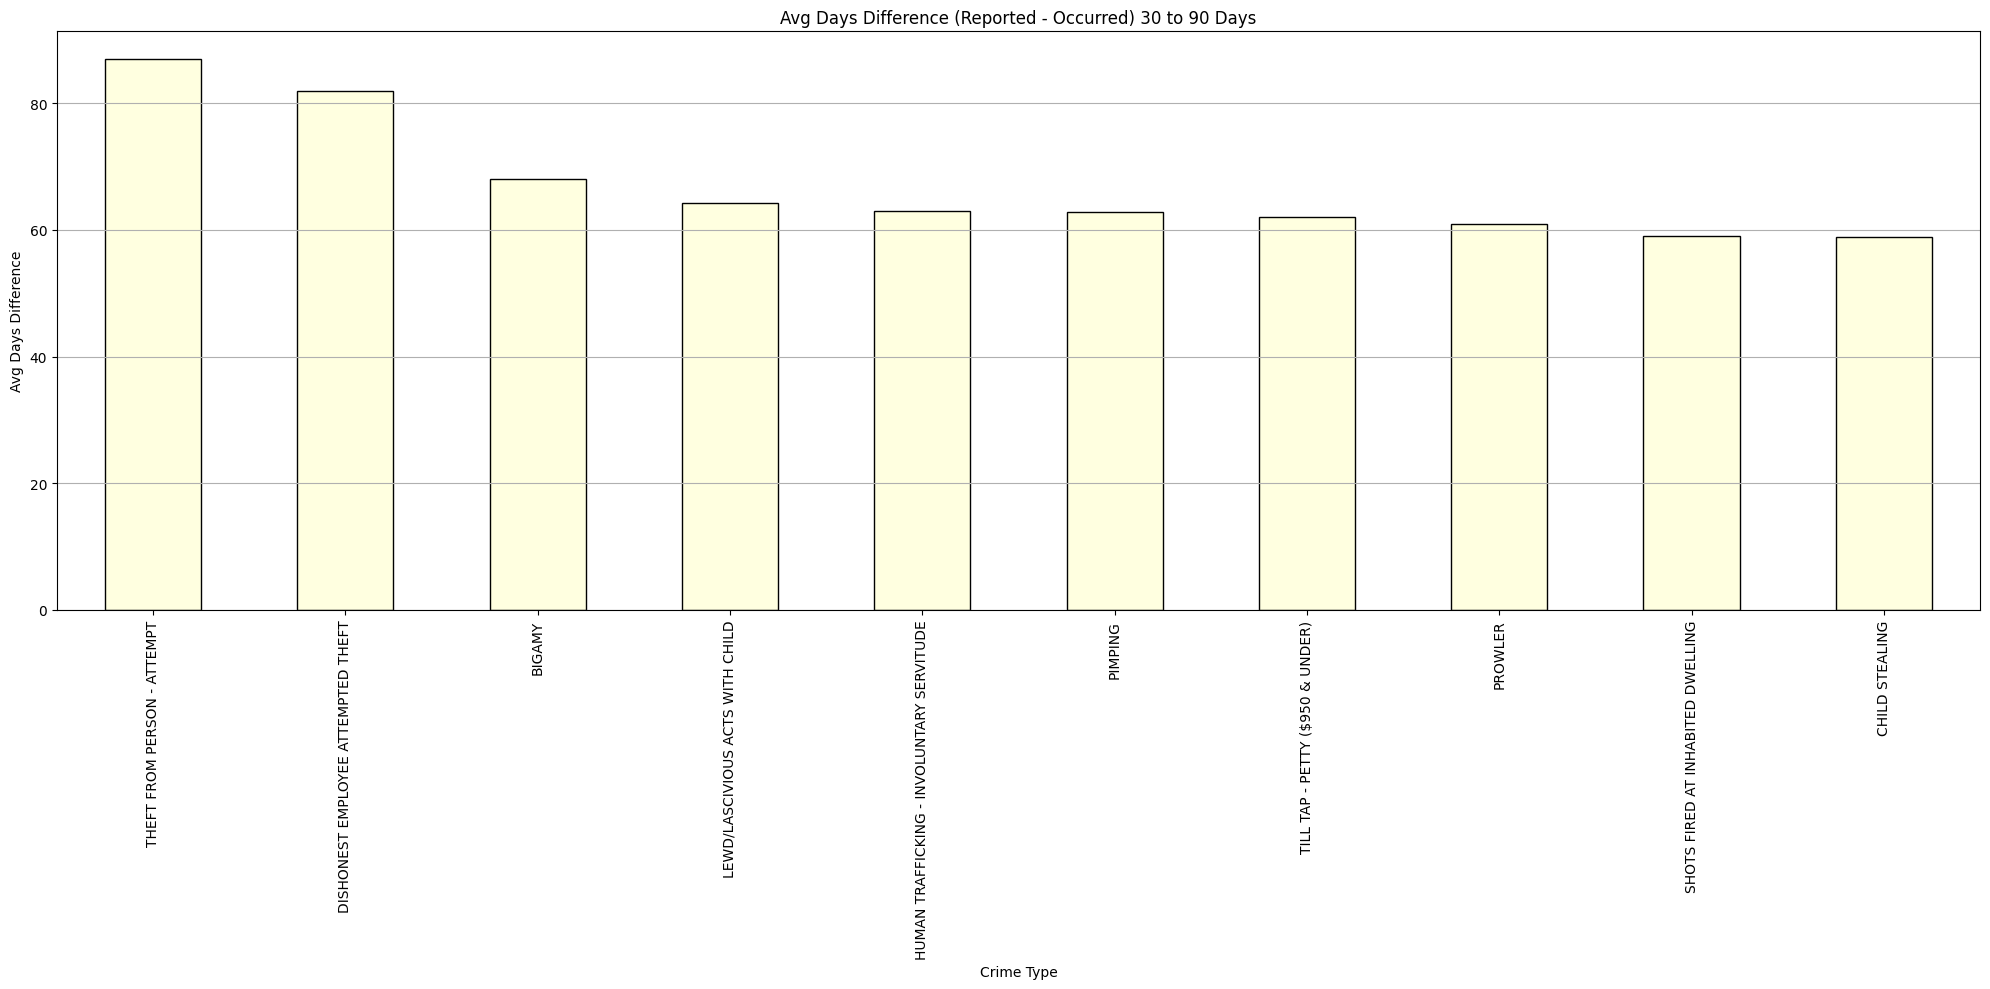

In [41]:
df_between_30_90 = df[(df['date_diff'] > 30) & (df['date_diff'] <= 90)]
crime_diff_between_30_90 = df_between_30_90.groupby('crime_code_description')['date_diff'].mean().sort_values()

crime_diff_between_30_90=crime_diff_between_30_90.nlargest(10)

plt.figure(figsize=(20, 10))
crime_diff_between_30_90.plot(kind='bar', color='lightyellow', edgecolor='black')
plt.title('Avg Days Difference (Reported - Occurred) 30 to 90 Days')
plt.xlabel('Crime Type')
plt.ylabel('Avg Days Difference')
plt.xticks(rotation=90)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

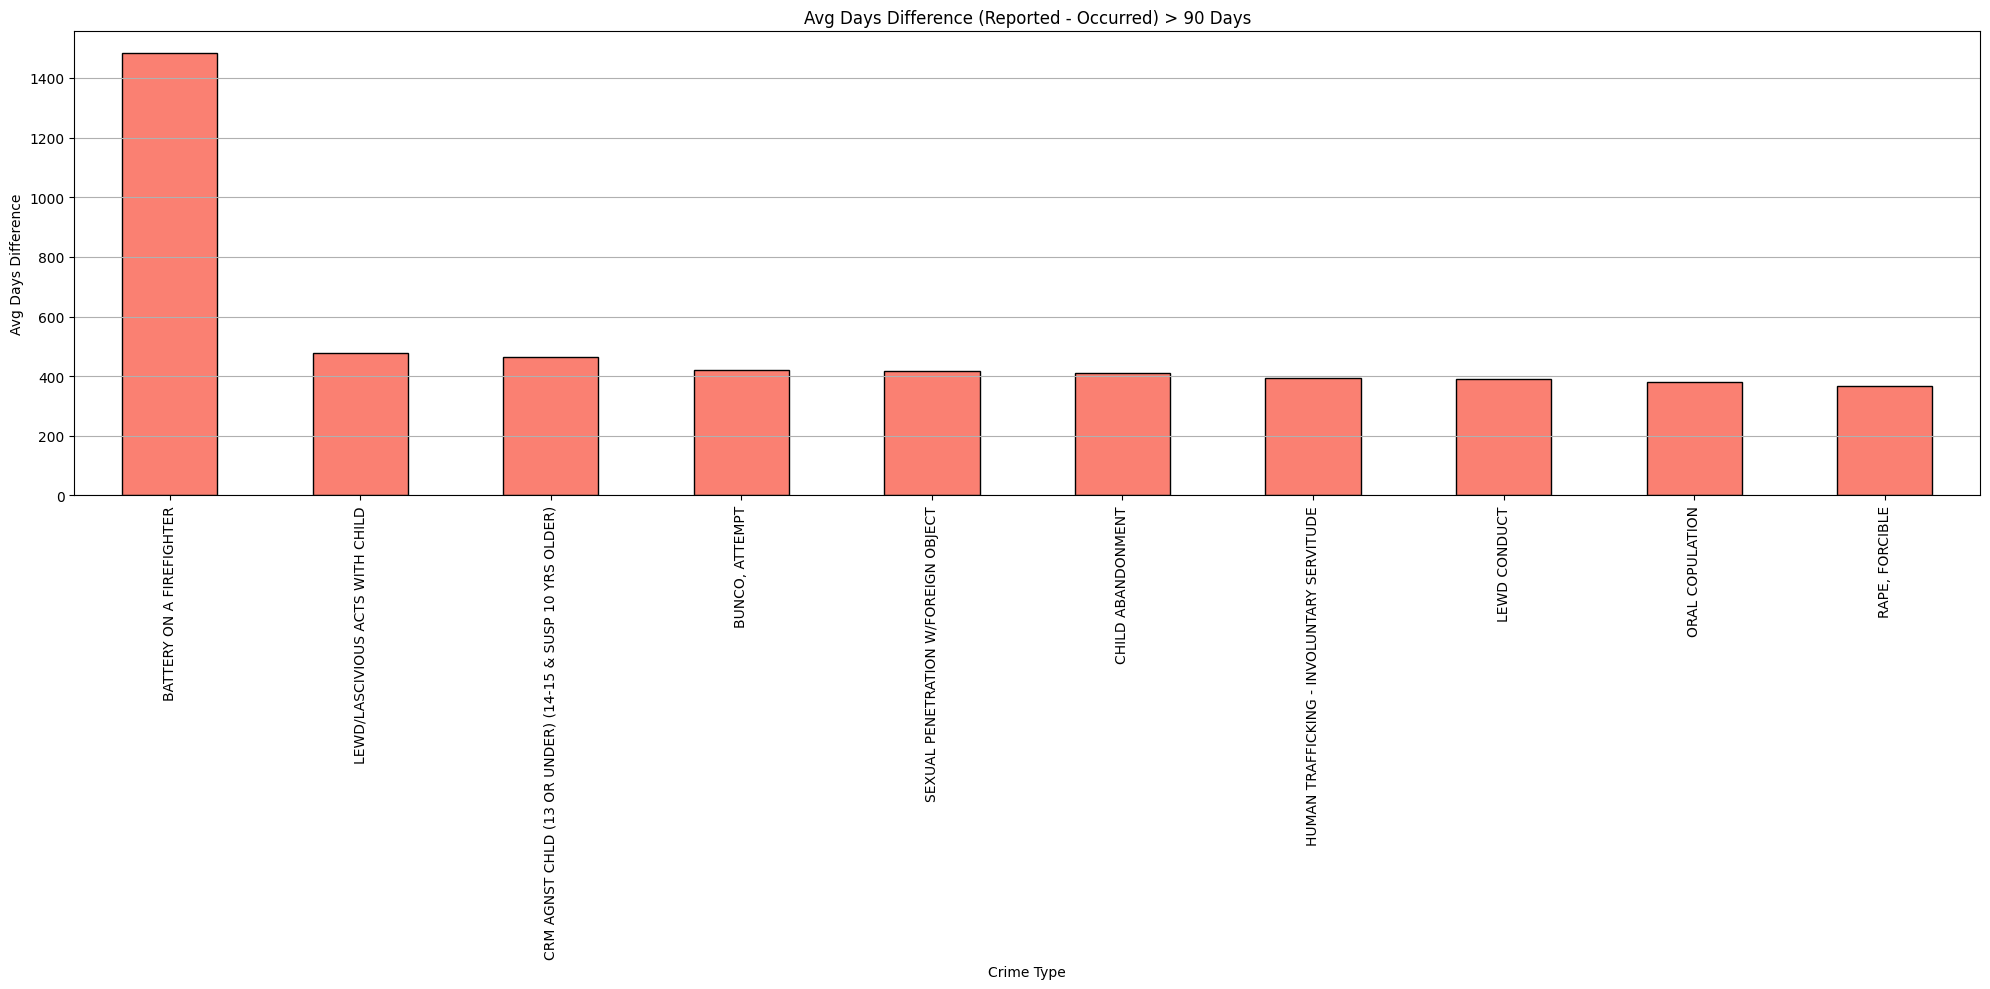

In [42]:
df_over_90 = df[df['date_diff'] > 90]
crime_diff_over_90 = df_over_90.groupby('crime_code_description')['date_diff'].mean().sort_values()

crime_diff_over_90=crime_diff_over_90.nlargest(10)

plt.figure(figsize=(20, 10))
crime_diff_over_90.plot(kind='bar', color='salmon', edgecolor='black')
plt.title('Avg Days Difference (Reported - Occurred) > 90 Days')
plt.xlabel('Crime Type')
plt.ylabel('Avg Days Difference')
plt.xticks(rotation=90)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

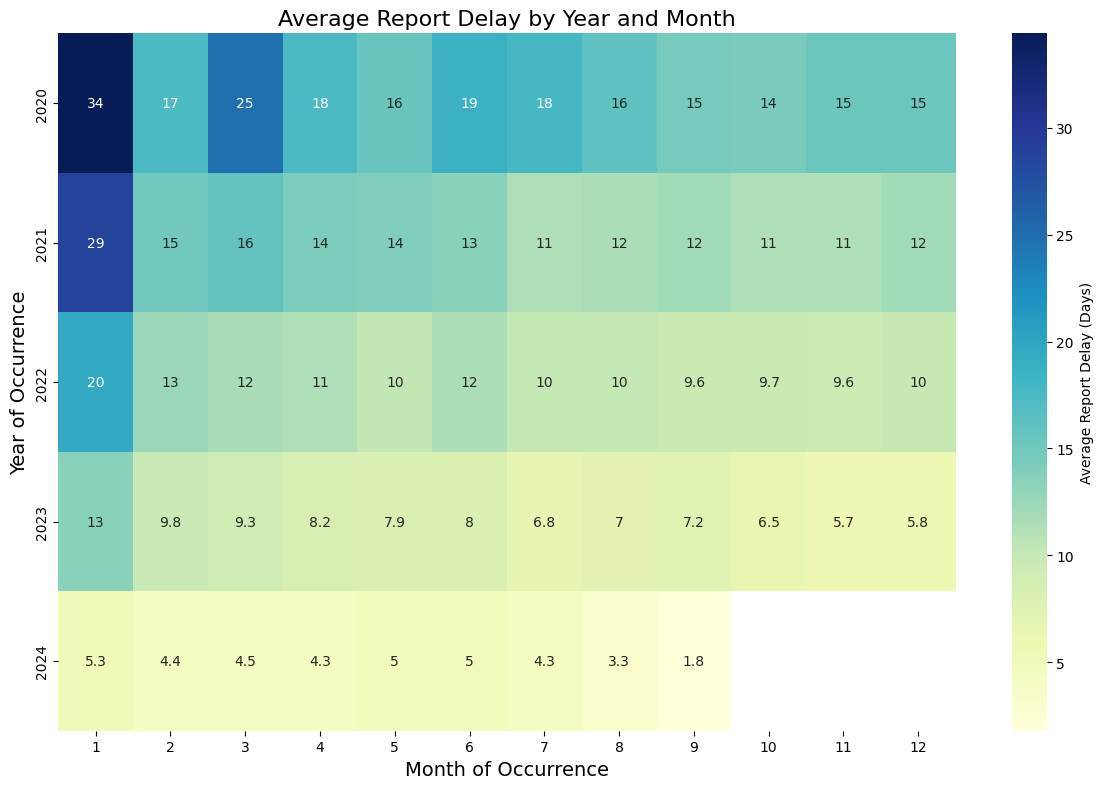

In [47]:
# Ensure the 'date_occurred' and 'date_reported' columns are in datetime format
df['date_occurred'] = pd.to_datetime(df['date_occurred'])
df['date_reported'] = pd.to_datetime(df['date_reported'])

# Extract year and month from the date occurred and date reported
df['year_occurred'] = df['date_occurred'].dt.year
df['month_occurred'] = df['date_occurred'].dt.month
df['year_reported'] = df['date_reported'].dt.year
df['month_reported'] = df['date_reported'].dt.month

# Calculate report delay in days
df['report_delay'] = (df['date_reported'] - df['date_occurred']).dt.days

# Group by year and month to calculate average report delay
report_delay_by_time = df.groupby(['year_occurred', 'month_occurred'])['report_delay'].mean().unstack()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(report_delay_by_time, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Average Report Delay (Days)'})

# Add title and labels
plt.title("Average Report Delay by Year and Month", fontsize=16)
plt.xlabel("Month of Occurrence", fontsize=14)
plt.ylabel("Year of Occurrence", fontsize=14)
plt.tight_layout()

# Show plot
plt.show()